In [37]:
import numpy as np
import matplotlib.pyplot as plt
#import odeint
from scipy.integrate import odeint
# import brentq
from scipy.optimize import brentq
from solveTmu import blackness
# import solve_ivp
from scipy.integrate import solve_ivp
# import interp1d from scipy
from scipy.interpolate import interp1d
"Matching Fang paper"
v4=4.2
v3= -22.6/(6*np.sqrt(2))


def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    u=np.linspace(ui,uf,1000)
    u_backward=np.linspace(uf,ui,1000)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))


    "IR boundary condition"
    chi0=d0+d1*(1-uf)
    chip0=d1
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 

    mq=chip[0]/(zeta*zh)


    return mq,chi,chip,u

def sigma_finder(chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    u_intermediate=0.15
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma

from joblib import Parallel, delayed

def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array)

In [3]:
T=130
mu=0
lambda1=7
ui=1e-4
uf=1-ui
zeta=np.sqrt(3)/(2*np.pi)
#Use brentq to find the value of d0 that gives mq=mq_input
mq_input=24
def find_d0(d0):
    mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
    return mq-mq_input

d0=brentq(find_d0,0,1)
print("d0 is ", d0)
#Find sigma
sigma=sigma_finder(chi,u,mq,T,mu,zeta,v3)
print("sigma is ", sigma)
print("sl is ", (sigma)**(1/3 ))

mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
print("quark mass is ", mq)
plt.loglog(u,chi)
plt.show()





d0 is  0.6961493861617327


NameError: name 'chi' is not defined

In [229]:
# create an array of d0 values and plot the quark mass as a function of d0
T=80
mu=0
lambda1=7
d0_array=np.linspace(0,2,1000)
mq_array=np.zeros(len(d0_array))
for i in range(len(d0_array)):
    mq_array[i],chi,chip,u=chiral_solve_IR(d0_array[i],lambda1,T,mu,ui,uf)


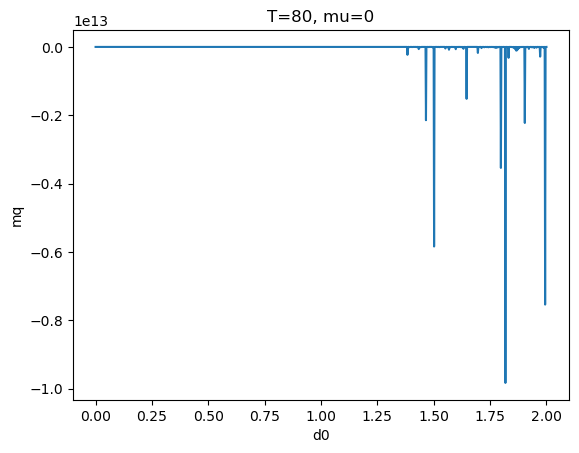

In [231]:
plt.plot(d0_array,mq_array)
# plt.ylim(0,28)
# plt.xlim(0,.5)
plt.xlabel('d0')
plt.ylabel('mq')
#plot a horizontal line at mq=24
# plt.axhline(y=24.8, color='r', linestyle='-')
#title the plot with temperature and mu values
plt.title('T='+str(T)+', mu='+str(mu))
plt.show()

In [214]:
# find the index where mq is closest to 24
index=np.argmin(np.abs(mq_array-24))
print("d0 is ", d0_array[index])
print("mq is ", mq_array[index])

d0 is  0.1781781781781782
mq is  23.979433396268725


In [228]:
#find indices where absolute value of quark mass is greater than 100, and remove them from mq_array and d0_array
indices=np.where(np.abs(mq_array)>100)[0]
mq_array=np.delete(mq_array,indices)
d0_array=np.delete(d0_array,indices)
mq_input=24.8
# find the indices where mq_array-mq_input changes sign
sign_change=np.where(np.diff(np.sign(mq_array-mq_input)))[0]
# find the d0 values at the sign change
d0_array[sign_change]
#print the d0 values at the sign change
print("d0 values at sign change are ", d0_array[sign_change])
# find the mq values at the sign change
mq_array[sign_change]
#print the mq values at the sign change
print("mq values at sign change are ", mq_array[sign_change])


d0 values at sign change are  [0.24224224 0.26826827 0.27427427]
mq values at sign change are  [24.79784687 24.88541561 24.79790425]


In [35]:
min(mq_array)

-141727511738.66812

In [158]:
mq_new,chi,chip,u=chiral_solve_IR(d0_lower,lambda1,T,mu,ui,uf)


NameError: name 'd0_lower' is not defined

In [40]:
d0_array=np.linspace(0,10,100000)

In [41]:
mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

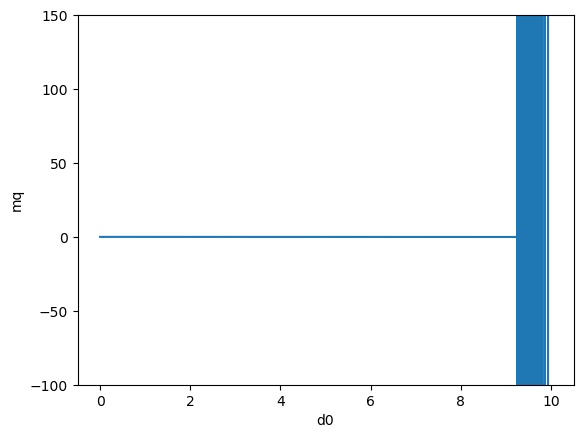

In [44]:
plt.plot(d0_array,np.gradient(mq_array))
plt.ylim(-100,150)
plt.xlabel('d0')
plt.ylabel('mq')
plt.show()


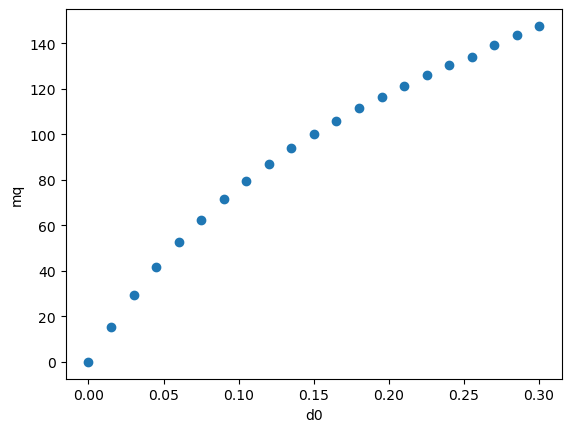

In [233]:
mq_input=1e-2
T=200
min_d0=0
max_d0=15
d0_array=np.linspace(min_d0,max_d0,1000)
mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

# find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
indices=np.where(np.abs(mq_array)>150)
# we don't need to go higher than the lowest d0 value that gives garbage results
# if indices is not an empty array
if len(indices[0])>0:
    max_d0=d0_array[indices[0]]
if len(indices[0])>1:
    max_d0=max_d0[0]

d0_array=np.delete(d0_array,indices)
mq_array=np.delete(mq_array,indices)

iterations=0
step_size=d0_array[1]-d0_array[0]

while max(mq_array)<mq_input and iterations<12:

    #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
    step_size=step_size/10
    d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
    d0_array=np.concatenate((d0_array,d0_new))
    #calculate the mq_array for the new d0_array
    mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)
    #add the new mq_array to the old mq_array
    mq_array=np.concatenate((mq_array,mq_new))
    indices=np.where(np.abs(mq_array)>1000)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]    
    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)
    # print(max_d0)
    old_max_d0=max_d0
    iterations=iterations+1

plt.scatter(d0_array,mq_array)
# plt.ylim(-100,150)
# find the index where abs(mq_array) is first greater than 1
index=np.where(np.abs(mq_array)>1)[0][0]
# plt.xlim(d0_array[index-1],d0_array[-1])
plt.xlabel('d0')
plt.ylabel('mq')
plt.show()

    

In [206]:
iterations

12

In [96]:
T=40
d0_array=np.linspace(0,10,100)    
mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)
# find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
indices=np.where(np.abs(mq_array)>150)
d0_array=np.delete(d0_array,indices)
mq_array=np.delete(mq_array,indices)
#create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
d0_new=np.arange(max(d0_array),max(d0_array)+(d0_array[-1]-d0_array[0])/10,((d0_array[1]-d0_array[0])/100))
d0_array=np.concatenate((d0_array,d0_new))
#calculate the mq_array for the new d0_array
mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)
#add the new mq_array to the old mq_array
mq_array=np.concatenate((mq_array,mq_new))
indices=np.where(np.abs(mq_array)>150)
d0_array=np.delete(d0_array,indices)
mq_array=np.delete(mq_array,indices)




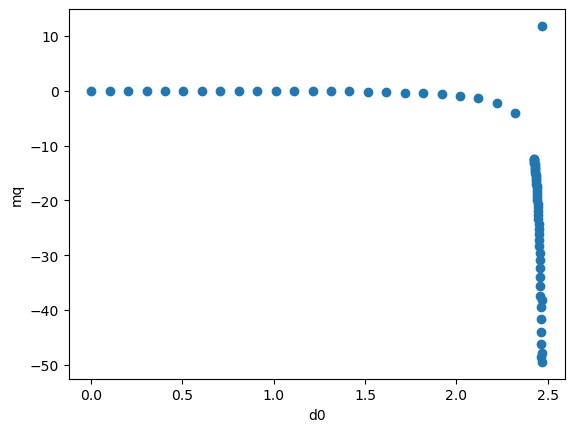

In [97]:
plt.scatter(d0_array,mq_array)
# plt.ylim(-200,150)
plt.xlabel('d0')
plt.ylabel('mq')
plt.show()

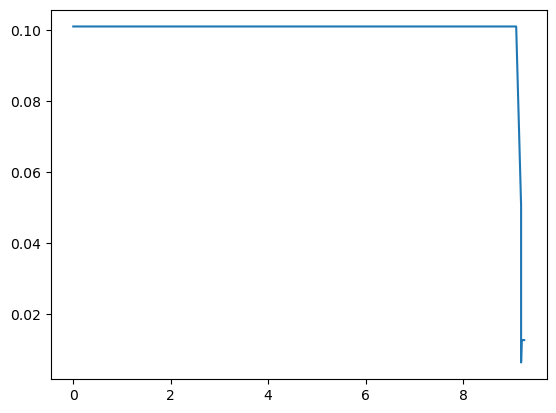

In [61]:
plt.plot(d0_array,np.gradient(d0_array))
plt.show()

In [99]:
mq_array[-1]

11.821156302806466